In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.core import *
from PIL import Image
from sklearn.metrics import confusion_matrix

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [70]:
from dataclasses import dataclass
from abc import abstractmethod
import numpy as np
from tqdm import tqdm

In [5]:
import pandas as pd
import numpy as np

In [6]:
import torch
import torch.nn.functional as F

In [7]:
from typing import Dict

import pathlib
import random

# MNIST classifier

## loading raw images into `d_images`

In [8]:
DIR_MNIST = untar_data(URLs.MNIST)

In [9]:
(DIR_MNIST/'training').ls()

(#10) [Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/9'),Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/0'),Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/7'),Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/6'),Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/1'),Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/8'),Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/4'),Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/3'),Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/2'),Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/5')]

In [10]:
def load_folder(folder:pathlib.Path) -> Dict[int,torch.tensor]:

    d_images = {}
    for folder_digit in sorted(folder.iterdir()):
        l = [
            np.array(Image.open(fname))
            for fname in get_files(folder_digit)
        ]
        digit = int(folder_digit.name)
        d_images[digit] = torch.tensor(l).float()

    return d_images

In [11]:
d_images = load_folder(DIR_MNIST / 'training')

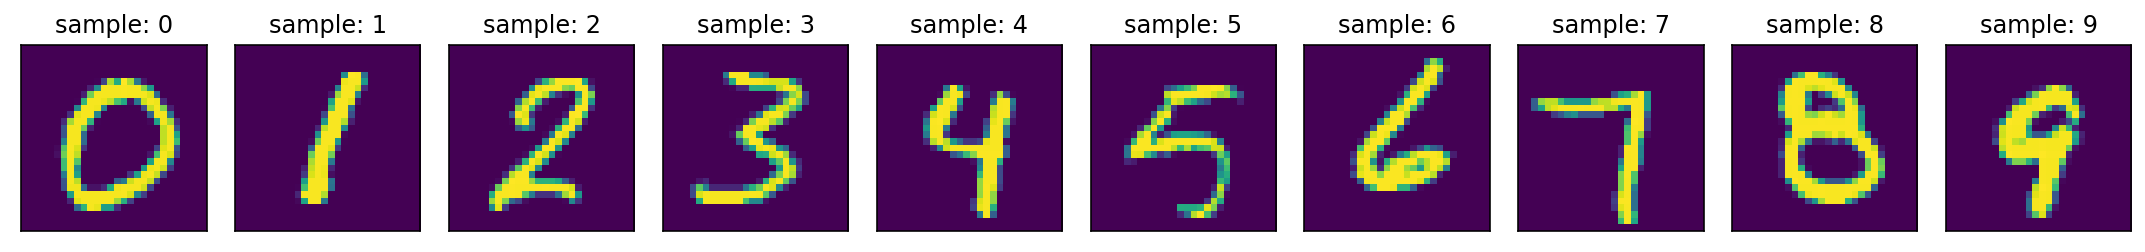

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,3))

for digit, ax in enumerate(axes):
    im = d_images[digit][0].numpy()
    ax.imshow(im)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(f'sample: {digit}')
    
plt.tight_layout()

## class prototypes

### define digit "prototypes" `d_proto`

In [13]:
d_proto = {}

for digit, batch in sorted(d_images.items()):
    d_proto[digit] = batch.mean(dim=0)

In [14]:
protos = torch.stack(list(d_proto.values()))

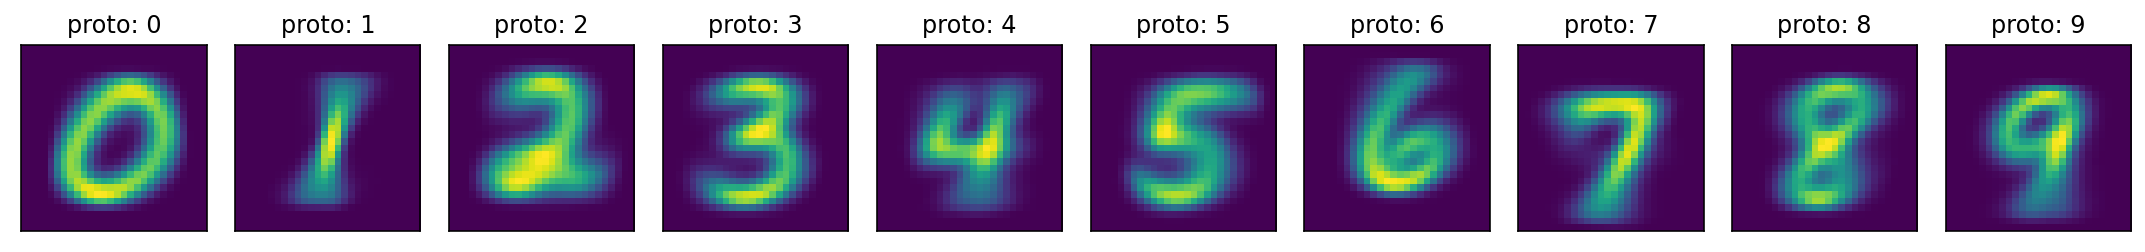

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,3))

for digit, ax in enumerate(axes):
    ax.imshow(d_proto[digit].numpy())
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(f'proto: {digit}')
    
plt.tight_layout()

### classifying a random sample using prototypes

In [16]:
np.random.seed(101)
SAMPLES = 100

In [17]:
d_idx_samples = {}

for digit in range(10):
    d_idx_samples[digit] = np.random.randint(0, d_images[digit].shape[0], SAMPLES)

In [18]:
def RMSE(im1, im2):
    # use mean((-1,-2)) so to support im1 with both 2 and 3 axes
    return (im1 - im2).pow(2).mean(dim=(-1,-2)).sqrt()

In [19]:
im = d_images[3][0]

RMSE(im, d_proto[3]).item()

52.70836639404297

In [20]:
# Note: pytorch already have a function to compute MSE
# ...we just need to apply sqrt() to it
F.mse_loss(im, d_proto[3]).sqrt().item()

52.70836639404297

In [21]:
def classify(im, protos, dist_fn=RMSE):
    return dist_fn(im, protos)

In [22]:
res = []
for y_true, idx_selected in d_idx_samples.items():
    batch = d_images[y_true][idx_selected]
    for im, idx in zip(batch, idx_selected):
        loss, y_pred = classify(im, protos).min(dim=0)
        res.append((y_true, y_pred.item(), idx))

In [23]:
df_pred = pd.DataFrame(res, columns=['y_true', 'y_pred', 'idx_selected'])

In [24]:
df_pred

,y_true,y_pred,idx_selected
0,0,0,4959
1,0,0,1547
2,0,0,1361
3,0,0,5695
4,0,0,599
...,...,...,...
995,9,9,4086
996,9,9,874
997,9,9,1231
998,9,9,1053


In [25]:
conf_mtx = confusion_matrix(df_pred['y_true'], df_pred['y_pred'])

In [26]:
conf_mtx = pd.DataFrame(conf_mtx)

Text(0.5, 15.0, 'prediction')

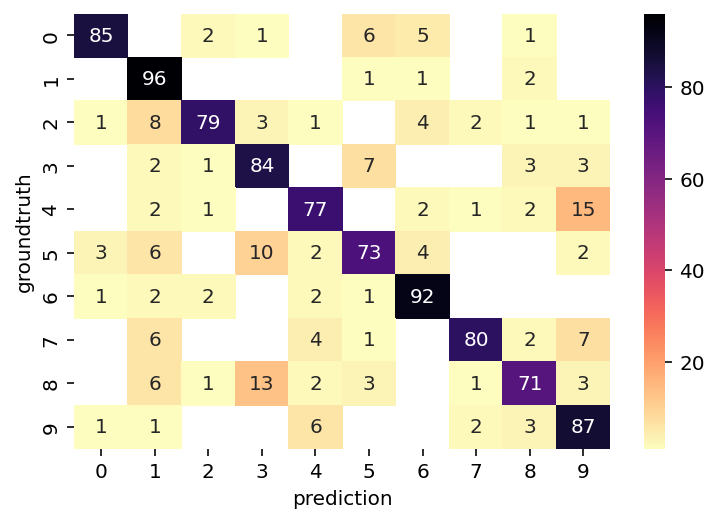

In [27]:
ax = sns.heatmap(
    data=conf_mtx.replace({0:np.nan}),
    annot=True,
    cmap='magma_r',
)
ax.set_ylabel('groundtruth')
ax.set_xlabel('prediction')

### investigate misclassifications

In [28]:
def plot_grid(df_pred, y_true, y_pred):
    df_tmp = df_pred[
        (df_pred['y_true'] == y_true) 
        & (df_pred['y_pred'] == y_pred)
    ]

    fig, axes = plt.subplots(nrows=1, ncols=df_tmp.shape[0], figsize=(15, 3))

    for ax, row in zip(axes, df_tmp.itertuples()):
        ax.imshow(d_images[row.y_true][row.idx_selected])
        ax.set_title(f'idx:{row.idx_selected}')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    plt.tight_layout()
    
    return df_tmp

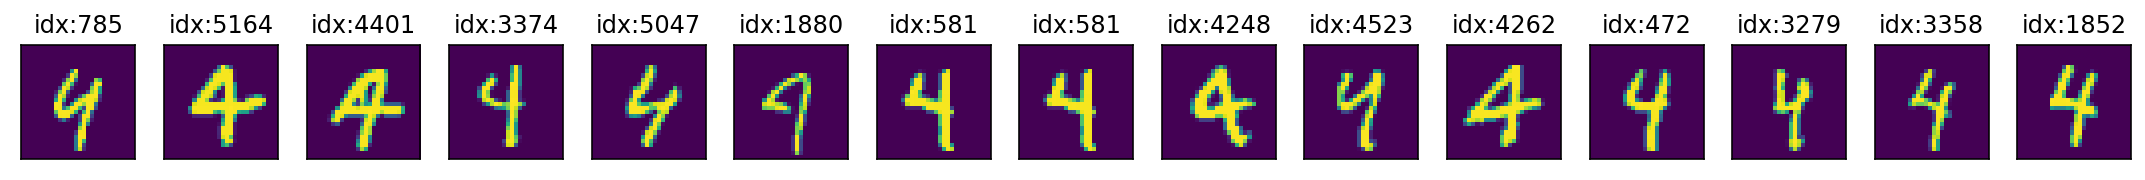

In [29]:
_ = plot_grid(df_pred, y_true=4, y_pred=9)

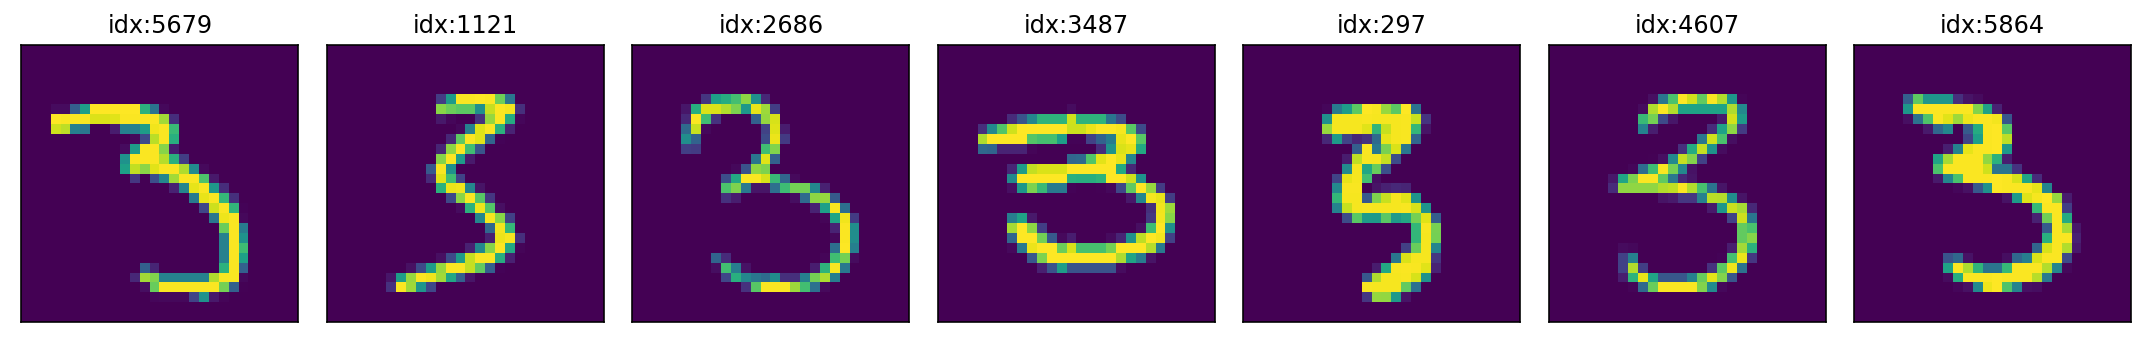

In [30]:
_ = plot_grid(df_pred, y_true=3, y_pred=5)

In [31]:
def plot_classify(y_true, idx_selected):
    im = d_images[y_true][idx_selected]
    
    pred = classify(im, protos)
    loss, y_pred = pred.min(dim=0)
    y_pred = y_pred.item()
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,3))
    
    ax = axes[0]
    pd.Series(pred.numpy()).sort_values(ascending=False).plot(
        ax=ax, 
        kind='barh', 
        rot=0
    )
    ax.set_title('distance')
    ax.set_ylabel('label')
    
    axes[1].imshow(im)
    axes[1].set_title('image')
    
    axes[2].imshow(d_proto[y_true])
    axes[2].set_title(f'expected proto: {y_true}')
    
    axes[3].imshow(d_proto[y_pred])
    axes[3].set_title(f'predicted proto: {y_pred}')
    
    plt.tight_layout()

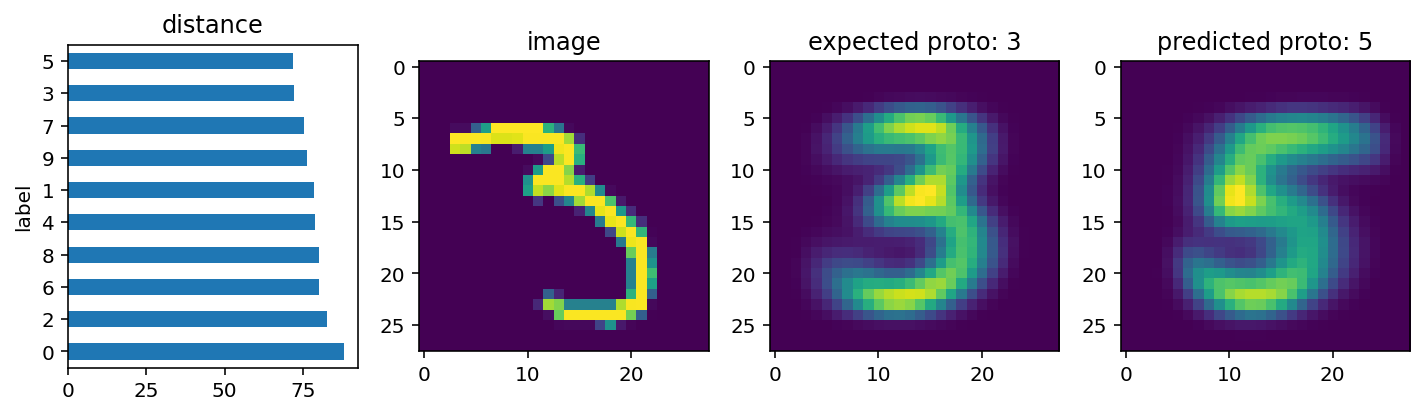

In [32]:
plot_classify(3, 5679)

### classify all images using prototypes

In [33]:
def classify_images(d_images, protos, dist_fn=RMSE):
    res = []
    labels = list(d_images.keys())
    for y_true, batch in d_images.items():
        for idx, im in enumerate(batch):
            _, y_pred = classify(im, protos, dist_fn).min(dim=0)
            y_pred = labels[y_pred.item()]
            res.append((y_true, y_pred, idx))

    df_pred = pd.DataFrame(res, columns=['y_true', 'y_pred', 'idx_selected'])
    return df_pred

In [34]:
df_pred_all = classify_images(d_images, protos)

In [35]:
def plot_conf_mtx(df_pred):
    conf_mtx = pd.DataFrame(confusion_matrix(df_pred['y_true'], df_pred['y_pred']))
    df_tmp = conf_mtx.replace({0:np.nan})
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

    ax = axes[0]
    ax = sns.heatmap(
        ax=ax,
        data=df_tmp,
        annot=True,
        cmap='magma_r',
        fmt='.0f',
    )
    ax.set_xlabel('prediction')
    ax.set_ylabel('groundtruth')



    ax = axes[1]
    ax = sns.heatmap(
        ax=ax,
        data=df_tmp / df_tmp.sum(axis=1) * 100,
        annot=True,
        cmap='magma_r',
        fmt='.1f',
        vmin=0,
        vmax=100,
    )
    ax.set_xlabel('prediction')
    ax.set_ylabel('groundtruth')
    ax.set_title('Recall')

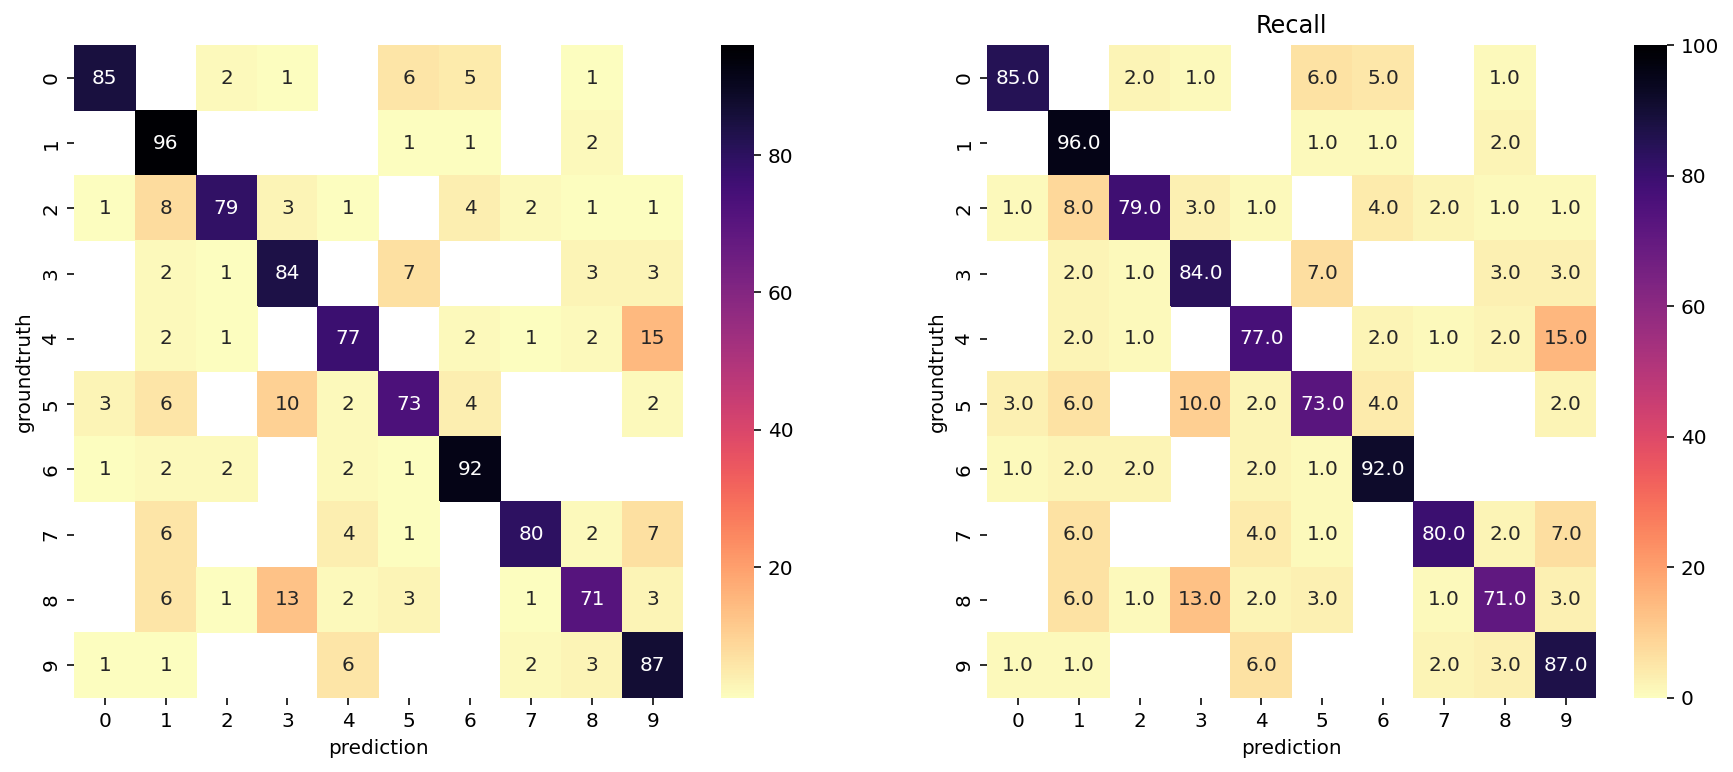

In [36]:
plot_conf_mtx(df_pred)

### classify the MNIST tes set using prototypes

In [37]:
d_images_val = load_folder(DIR_MNIST/'testing')

In [38]:
df_pred_testing = classify_images(d_images_val, protos)

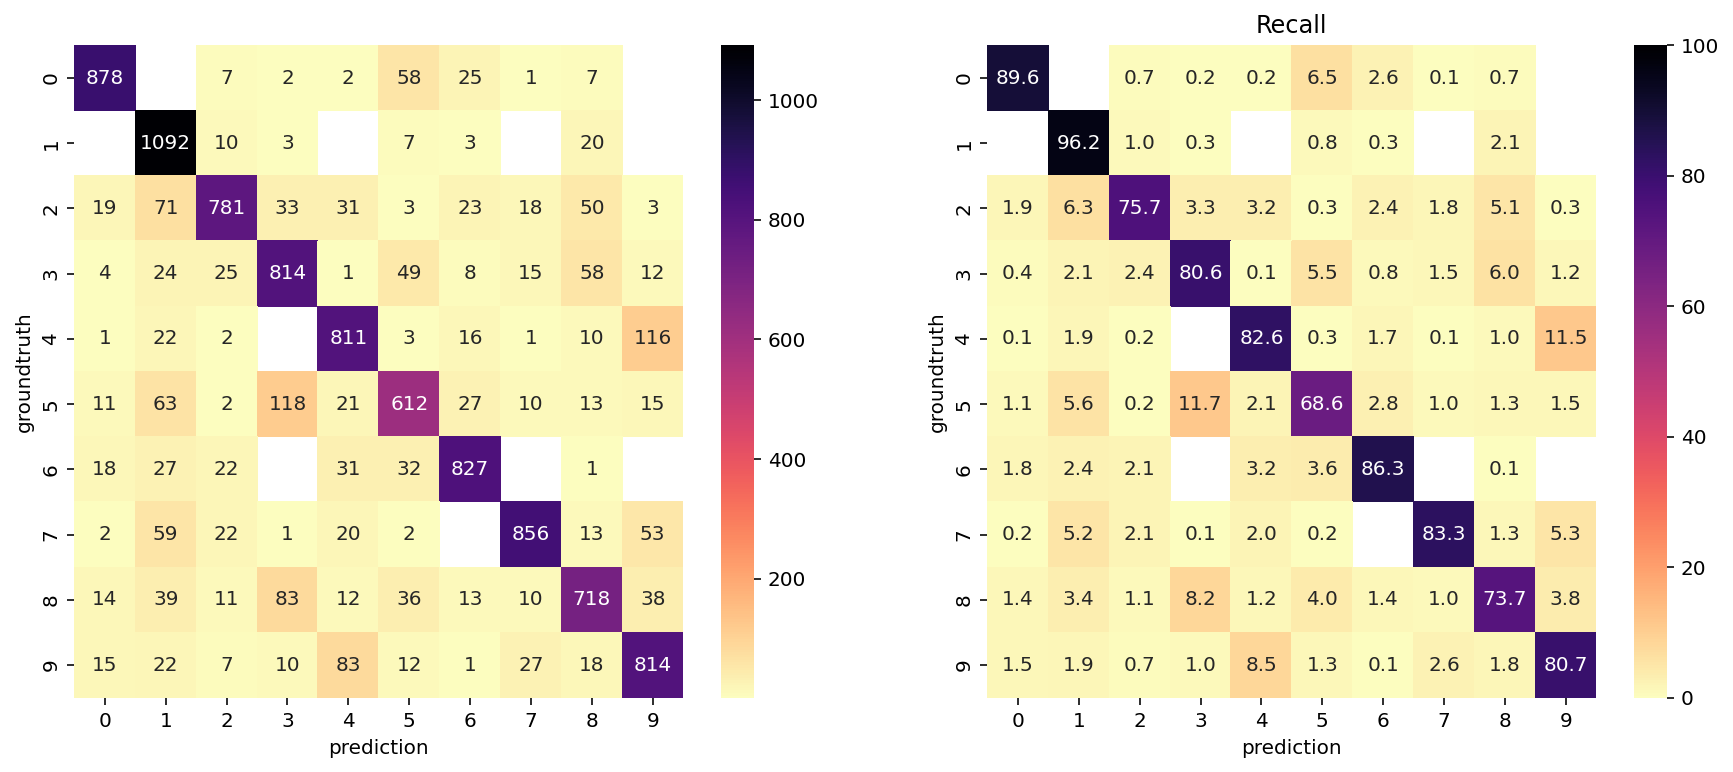

In [39]:
plot_conf_mtx(df_pred_testing)

In [40]:
correct = (df_pred_testing['y_true'] == df_pred_testing['y_pred']).sum()
print(f'Overall accuracy: {correct / df_pred_testing.shape[0] * 100:.2f}%')

Overall accuracy: 82.03%


### classifying using prototypes using only 3-and-7 classes

In [41]:
def MAE(im1, im2):
    return (im1 - im2).abs().mean((-1,-2))

In [42]:
df_pred_testing_3and7 = classify_images(
    {3:d_images_val[3], 7:d_images_val[7]},
    protos[[3,7]],
    MAE
)

In [43]:
correct = (df_pred_testing_3and7['y_true'] == df_pred_testing_3and7['y_pred']).sum()
print(f'Overall accuracy: {correct / df_pred_testing_3and7.shape[0] * 100:.2f}%')

Overall accuracy: 95.14%


In [44]:
correct = ((df_pred_testing_3and7['y_true'] == 3) & (df_pred_testing_3and7['y_pred'] == 3)).sum()
print(f'Overall accuracy: {correct / d_images_val[3].shape[0] * 100:.2f}%')

correct = ((df_pred_testing_3and7['y_true'] == 7) & (df_pred_testing_3and7['y_pred'] == 7)).sum()
print(f'Overall accuracy: {correct / d_images_val[7].shape[0] * 100:.2f}%')

Overall accuracy: 91.68%
Overall accuracy: 98.54%


# stocastic gradient descent

## parabol

In [45]:
np.random.seed(42)
torch.manual_seed(42)

In [46]:
def f(x, params):
    a,c = params
    return a*(x-10)**2 + c

In [47]:
x = torch.arange(21, dtype=np.float)

noise = torch.randint(-10, 10, size=x.shape)
params = (1, 10)
y_true = f(x, params) + noise

In [48]:
def plot_func(x, y_true, y_pred=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.scatter(x, y_true, label='f(x)')
    if y_pred is not None:
        ax.scatter(x, y_pred, label='y_pred')
    ax.legend()
    
    return ax

<AxesSubplot:>

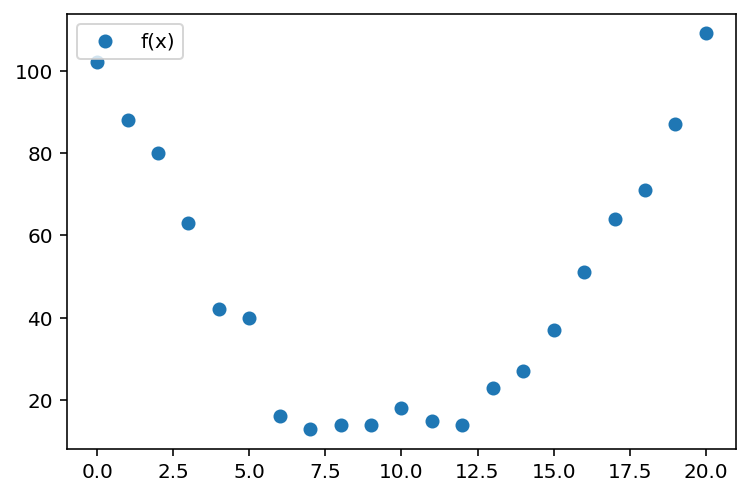

In [49]:
plot_func(x.numpy(), y_true.numpy())

In [50]:
# def loss(y_true, y_pred):
#     return (y_true - y_pred).pow(2).mean().sqrt()

In [51]:
LR = 0.01
EPOCHS = 50

In [52]:
def train_plot(x, y_true, y_pred, track_loss):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

    plot_func(x, y_true.numpy(), y_pred.numpy(), ax=axes[0])
    
    axes[1].plot(np.arange(len(track_loss)), track_loss, label='loss')
    axes[1].legend()
    
def train(x, y_true, n_params, f, epochs, lr):
    params = torch.randn(n_params).requires_grad_()

    track_loss = []

    for _ in range(epochs): 

        y_pred = f(x, params)

        loss = (y_true - y_pred).pow(2).mean().sqrt()
        track_loss.append(loss.item())

        params.grad = None
        loss.backward()
        params.data -= lr * params.grad.data
    
    return params, track_loss

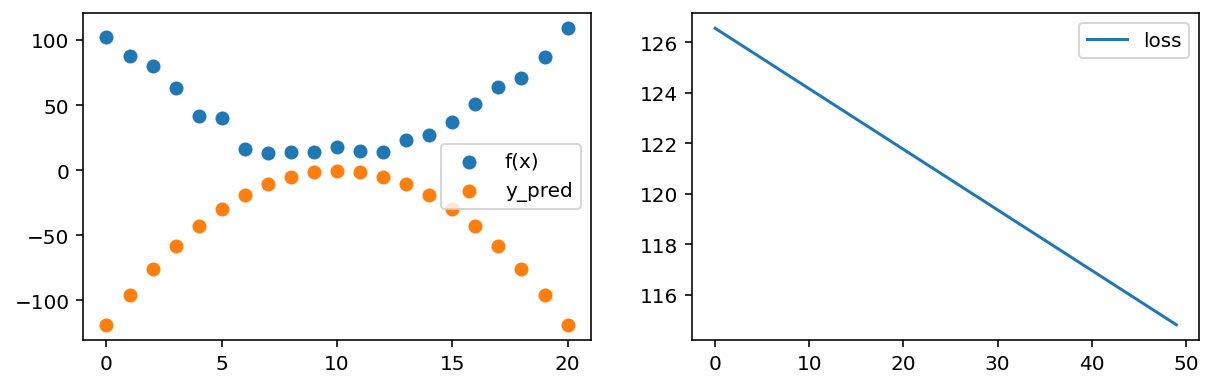

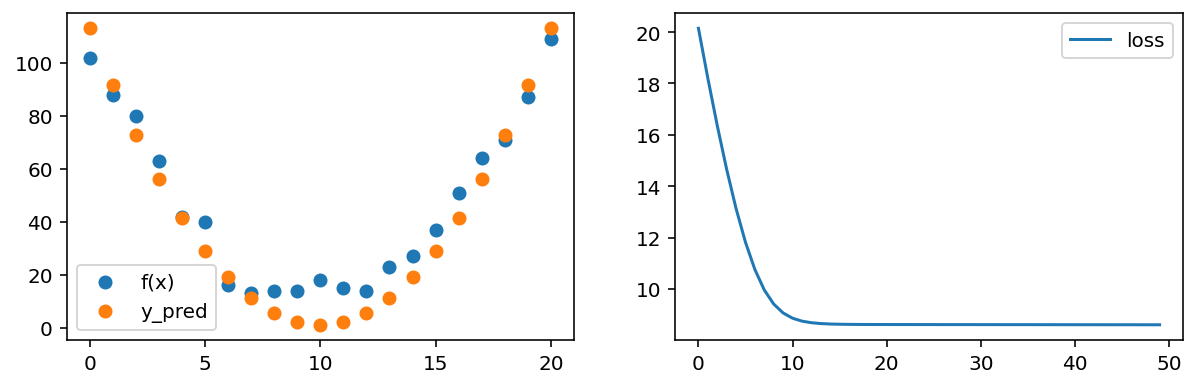

In [53]:
## too small learning rate
pred_params, track_loss = train(x, y_true, len(params), f, epochs=50, lr=10e-5)
y_pred = f(x, pred_params.data)
train_plot(x, y_true, y_pred, track_loss)

## larger value is better
pred_params, track_loss = train(x, y_true, len(params), f, epochs=50, lr=0.001)
y_pred = f(x, pred_params.data)
train_plot(x, y_true, y_pred, track_loss)

## parabol with 3 random parameters

In [54]:
np.random.seed(101)
torch.manual_seed(101)

In [55]:
def f2(x, params):
    a,b,c = params
    return a*(x-10)**2 + b*x + c

In [56]:
params = torch.randn(3) * 100
params

tensor([-139.0506,  -81.5238,  -32.0438])

<AxesSubplot:>

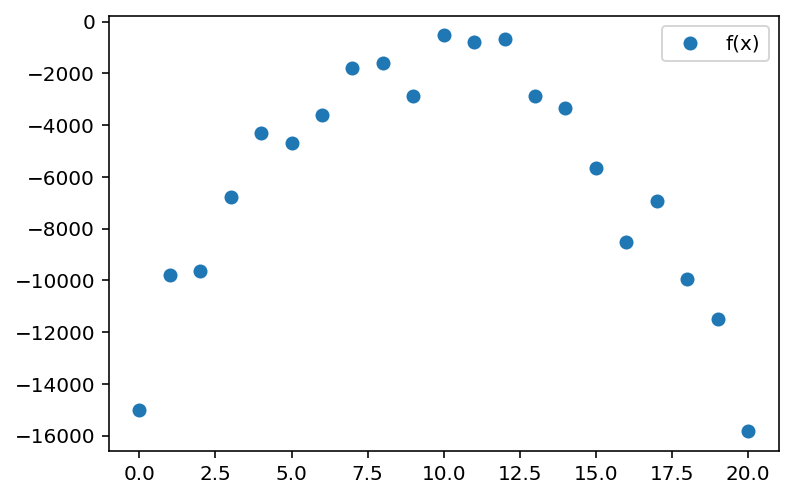

In [57]:
y_true = f2(x, params) + torch.randn_like(x)*1000
plot_func(x, y_true)

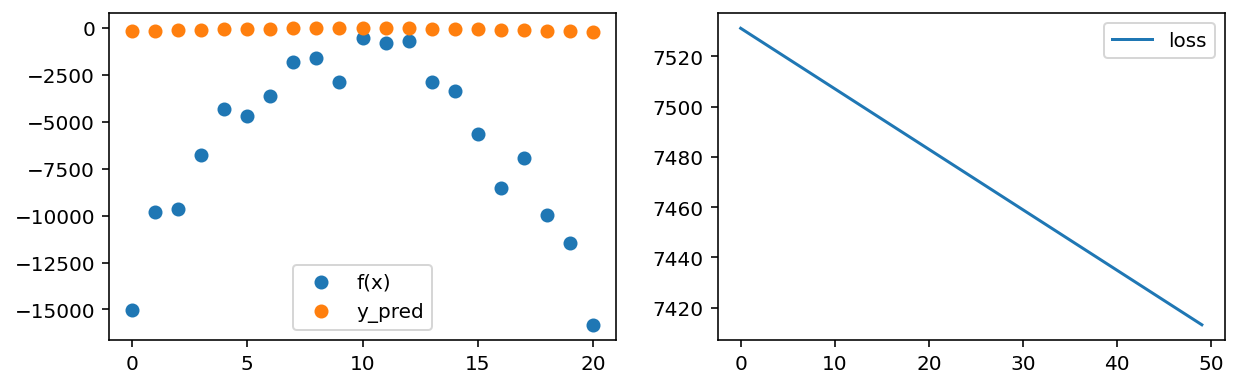

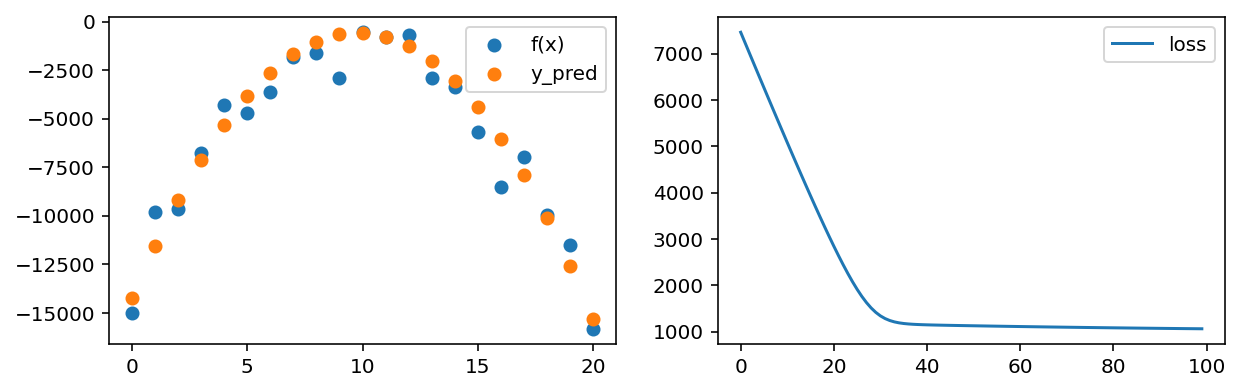

In [58]:
pred_params, track_loss = train(x, y_true, f=f2, n_params=params.shape[0], epochs=50, lr=0.001)
y_pred = f2(x, pred_params.data)
train_plot(x, y_true, y_pred, track_loss)

pred_params, track_loss = train(x, y_true, f=f2, n_params=params.shape[0], epochs=100, lr=0.1)
y_pred = f2(x, pred_params.data)
train_plot(x, y_true, y_pred, track_loss)

# SDG for binary MNIST (3-vs-7)

In [59]:
np.random.seed(42)
torch.manual_seed(42)

In [60]:
def dataprep(d_images, first_class, second_class):
    batch_x = []
    batch_y = []
    
    for idx, digit in enumerate((first_class, second_class)):
        X = torch.tensor(np.array(d_images[digit]), dtype=torch.float).view(-1, 28*28)
        X /= 255
        y = torch.zeros(X.shape[0], 1) + idx
        batch_x.append(X)
        batch_y.append(y)
    
    return torch.cat(batch_x), torch.cat(batch_y)

In [61]:
train_x, train_y = dataprep(d_images, first_class=3, second_class=7)
val_x, val_y = dataprep(d_images_val, first_class=3, second_class=7)

In [62]:
def train(train_loader, val_loader, lr=0.01, epochs=10):
    weights = torch.randn(28*28, requires_grad=True)
    bias = torch.randn(1, requires_grad=True)

    track_loss = []
    track_acc = []

    for _ in range(epochs):

        for x, y in train_loader:
            loss = (x @ weights + bias).sigmoid()
            loss = torch.where(y.squeeze()==0, 1-loss, loss)
            loss = loss.mean()

            loss.backward()

            weights.data -= lr * weights.grad.data
            bias.data -= lr * bias.grad.data
            weights.grad.zero_()
            bias.grad.zero_()

            track_loss.append(loss.item())

            # NOTE: it is overkilling doing it for every mini batch
            with torch.no_grad():
                acc = 0
                samples = 0

                for x, y in val_loader:
                    loss = (x @ weights + bias).sigmoid()

                    y_pred = torch.where(loss > 0.5, 0, 1)
                    acc += (y.squeeze() == y_pred).sum().item()
                    samples += x.shape[0]

                track_acc.append(acc / samples)
                
            
    return track_loss, track_acc, (weights, bias)

## Note: random generator seed

Following the suggestion posted here [https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/4](https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/4), to set the random seed we need to set
```
np.random.seed()
torch.manual_seel()
random.seed()
```

In [78]:
def init_random_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

## Note: impact of `lr` and `shuffle=True`

The book adopts two subtle choices:
1. `lr=1.` which is an unconventional choice with respect to literature but has __STRONG IMPACT__ on the results, as it speed up convergence 
2. `dl = DataLoader(dset, batch_size=256)` which means __NO SHUFFLE!__ as the default is `shuffle=False`. Again, this has __STRONG IMPACT__ and justifies the saber-tooth/square-gate of the loss---each epoch starts by optimizing the model to classify 3s, so the loss shoots when starts encoutering 7s 

By enabling shuffling 
- the behavior described in (2) is mitigated
- the training is still subject to the learning rate but converges faster

In [64]:
def get_loaders(train_x, train_y, val_x, val_y, batch_size=256, seed=42, shuffle_train=True):
    init_random_seed(seed)
    
    train_loader = DataLoader(list(zip(train_x, train_y)), bs=batch_size, shuffle=shuffle_train)
    val_loader = DataLoader(list(zip(val_x, val_y)), bs=batch_size, shuffle=False)

    return train_loader, val_loader

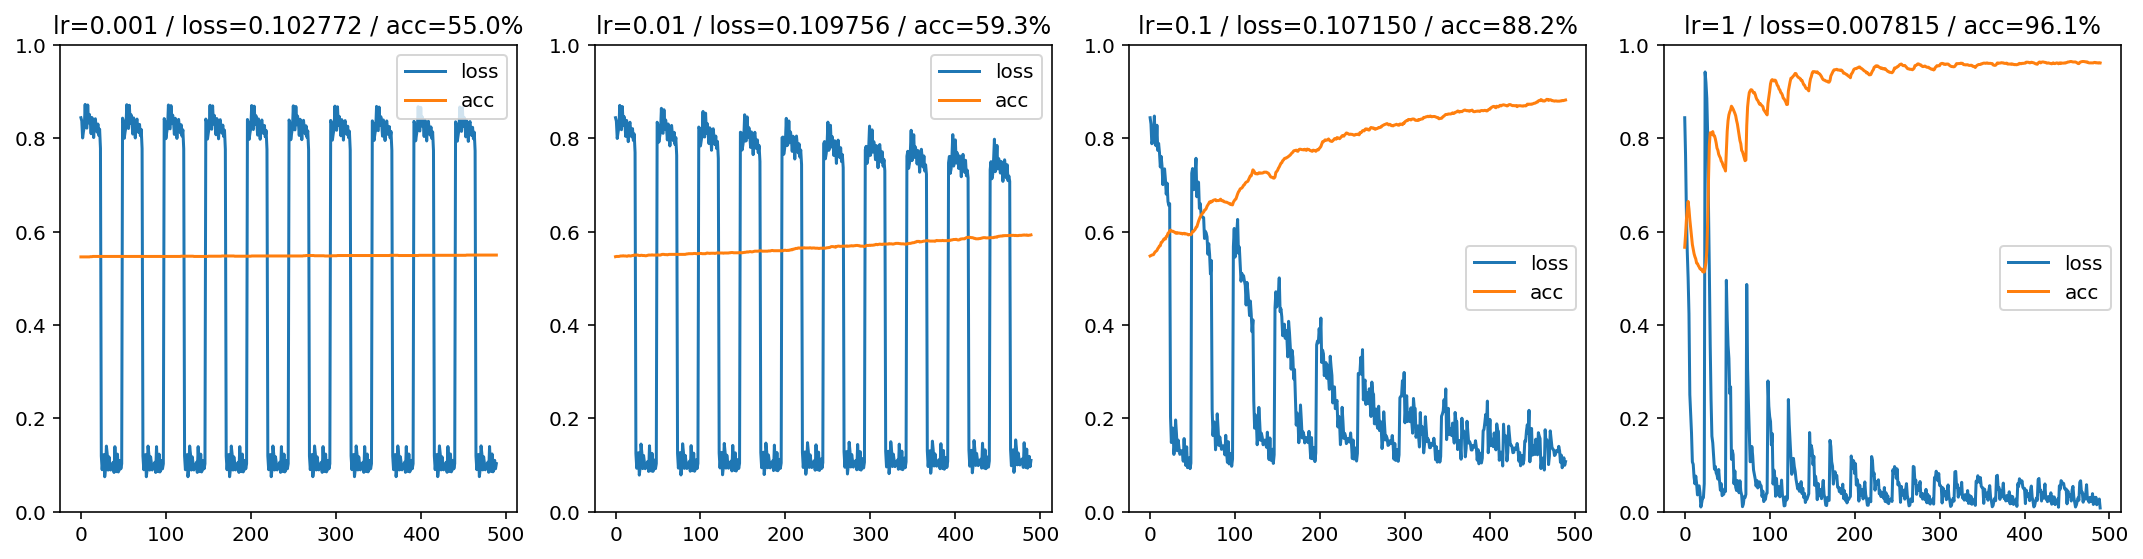

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,4))

for ax,lr in zip(axes, (0.001, 0.01, 0.1, 1)):

    train_loader, val_loader = get_loaders(train_x, train_y, val_x, val_y, shuffle_train=False)

    track_loss, track_acc, params = train(train_loader, val_loader, lr=lr, epochs=10)
    ax.plot(track_loss, label='loss')
    ax.plot(track_acc, label='acc')
    ax.set_title(f'lr={lr} / loss={track_loss[-1]:.6f} / acc={track_acc[-1]*100:.1f}%')
    ax.legend()
    ax.set_ylim(0, 1)
    
plt.tight_layout()

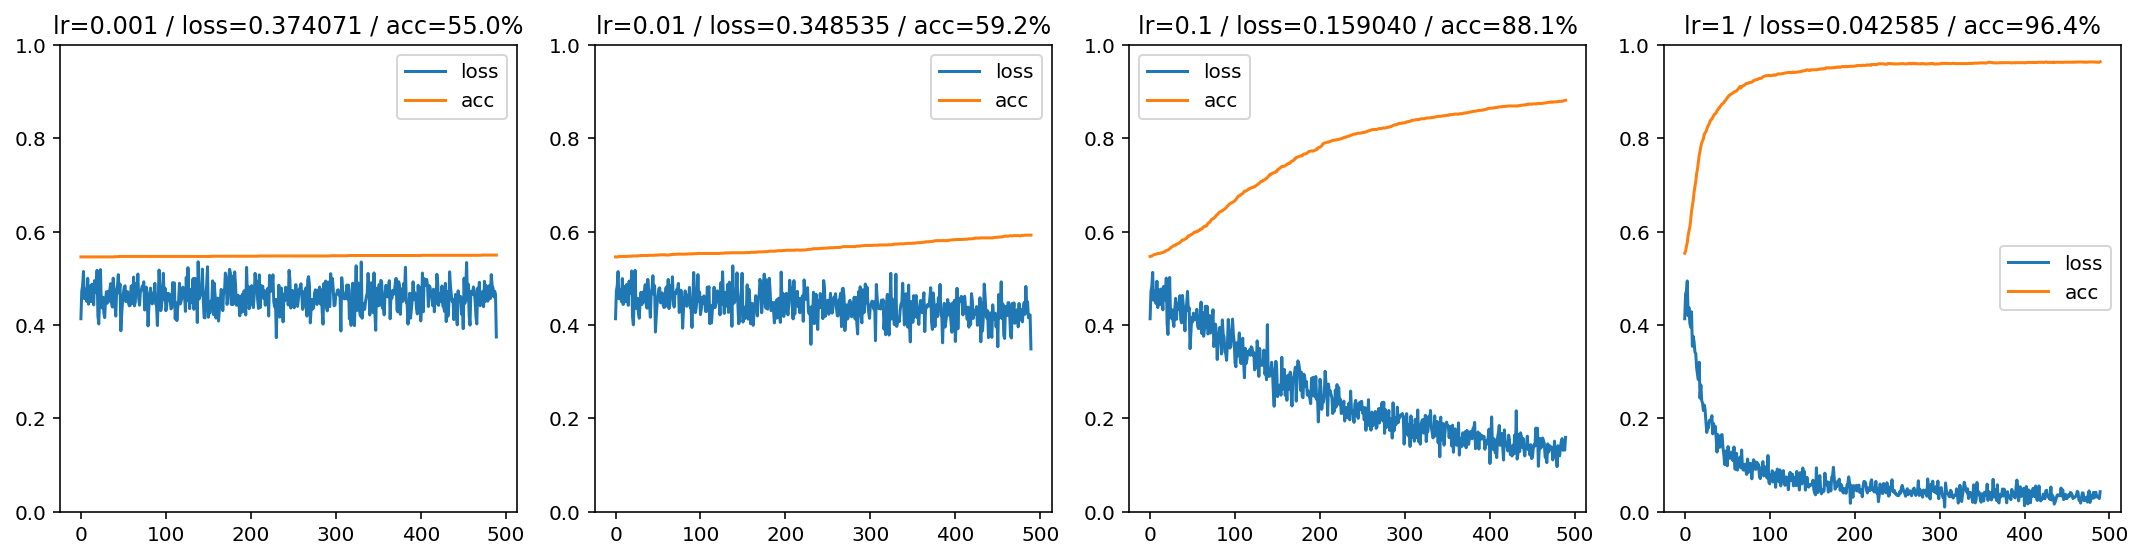

In [66]:
# repeat the same as above, but shuffling the training set

train_loader = DataLoader(list(zip(train_x, train_y)), bs=256, shuffle=True)
val_loader = DataLoader(list(zip(val_x, val_y)), bs=256, shuffle=False)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,4))

for ax,lr in zip(axes, (0.001, 0.01, 0.1, 1)):
    
    train_loader, val_loader = get_loaders(train_x, train_y, val_x, val_y, shuffle_train=True)
    
    track_loss, track_acc, params = train(train_loader, val_loader, lr=lr, epochs=10)
    ax.plot(track_loss, label='loss')
    ax.plot(track_acc, label='acc')
    ax.set_title(f'lr={lr} / loss={track_loss[-1]:.6f} / acc={track_acc[-1]*100:.1f}%')
    ax.legend()
    ax.set_ylim(0, 1)
    
plt.tight_layout()

## refactoring the previous code

Looking at the following code, the most obvious difference with respect to the book is the use of classes to obtain three entities:
- *model* contains the parameters and define their organization into layers
- *optimizer* defines how to update parameters
- *trainer* creates mini-batches, drives training and validation, and collects performance metrics

A __more subtle difference__ is the way metrics are computed.

Specifically, when running validation, the book computes the average accuracy per mini-back, and average those over one epoch, i.e., it computes *a mean of a mean*, which technically is not the *true aritmetic mean* as from the code in this notebook.

Worth mentioning also that running validation for each mini-batch might be too much of an overhead, but the MNIST dataset is small enough in this case.

### linear_layer()

In [210]:
def linear_layer(in_size, out_size):
    w = torch.zeros(in_size, out_size)
    b = torch.zeros(out_size)
    return (w,b)

### ModelSkeleton

In [79]:
@dataclass
class ModelSkeleton():
    params:list
    name:str = ''
    
    def __post_init__(self):
        self.zero_params()
    
    def zero_params(self):
        for tpl in self.params:
            for p in tpl:
                p.data = torch.zeros_like(p.data)
                
    @abstractmethod
    def predict(self, x):
        pass
    
    @abstractmethod
    def loss(self, y_pred, y_true):
        pass
    
    @abstractmethod
    def accuracy(self, y_pred, y_true):
        pass

### SingleLinearLayer

In [80]:
class SingleLinearLayerModel(ModelSkeleton):
    def __init__(self, size, *args, **kwargs):
        params = linear_layer(size, 1)
        super().__init__([params], *args, **kwargs)
    
    def predict(self, x):
        w, b = self.params[0]
        return (x@w + b).sigmoid()
    
    def loss(self, y_pred, y_true):
        return torch.where(y_true == 0, 1-y_pred, y_pred).mean()
    
    def accuracy(self, y_pred, y_true):
        pred_labels = torch.where(y_pred > 0.5, 0, 1)
        return (pred_labels == y_true).sum().item()

### ModelOptimizer

In [81]:
@dataclass
class ModelOptimizer():
    model:ModelSkeleton
    lr:float
    
    def __post_init__(self):
        self.randn_params()
    
    def randn_params(self):
        for params in self.model.params:
            for p in params:
                p.data = torch.randn_like(p)
                p.requires_grad_()

    def zero_grad(self):
        for tpl in self.model.params:
            for p in tpl:
                p.grad = None

    def step(self):
        for tpl in self.model.params:
            for p in tpl:
                p.data -= self.lr * p.grad

### ModelTrainer

In [223]:
@dataclass
class ModelTrainer():
    model:ModelSkeleton
    optimizer:ModelOptimizer
    train_x:torch.tensor
    train_y:torch.tensor
    val_x:torch.tensor
    val_y:torch.tensor
    batch_size:int = 256
    epochs:int = 2
    
    def __post_init__(self):
        self.metrics = self.reset_metrics()
    
    def dataloaders(self):
        train_dataloader = DataLoader(list(zip(self.train_x, self.train_y)), bs=self.batch_size, shuffle=True)
        val_dataloader = DataLoader(list(zip(self.val_x, self.val_y)), bs=self.batch_size, shuffle=False)
        return train_dataloader, val_dataloader
                
    def reset_metrics(self):
        self.metrics = {
            'loss': [],
            'acc': [],
        }
        
    def track_metric(self, metric, value):
        self.metrics[metric].append(value)
        
    def validate(self, val_dataloader):
        with torch.no_grad():
            acc = 0
            samples = 0
            for batch_x, y_true in val_dataloader:
                y_pred = self.model.predict(batch_x)
                acc += self.model.accuracy(y_pred, y_true)
                samples += batch_x.shape[0]
        return acc/samples
        
    def fit(self):
        train_dataloader, val_dataloader = self.dataloaders()
        self.reset_metrics()
        
        for _ in tqdm(range(self.epochs), total=self.epochs):
            for batch_x, y_true in train_dataloader:
                y_pred = self.model.predict(batch_x)
                loss = self.model.loss(y_pred, y_true)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                self.track_metric('loss', loss.item())
                self.track_metric('acc', self.validate(val_dataloader))
                
    def plot_metrics(self, ax=None):
        if ax is None:
            _, ax = plt.subplots()
        
        ax.plot(self.metrics['loss'], label='loss')
        ax.plot(self.metrics['acc'], label='acc')
        ax.set_ylim(0,1)
        ax.legend()
        
        title = '' if not self.model.name else f'name:{self.model.name} / '
        title += f'lr={self.optimizer.lr}\n'
        title += f'loss={self.metrics["loss"][-1]:.6f} / '
        title += f'acc={self.metrics["acc"][-1]*100:.1f}'
        ax.set_title(title)

## Single linear layer model performance

100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


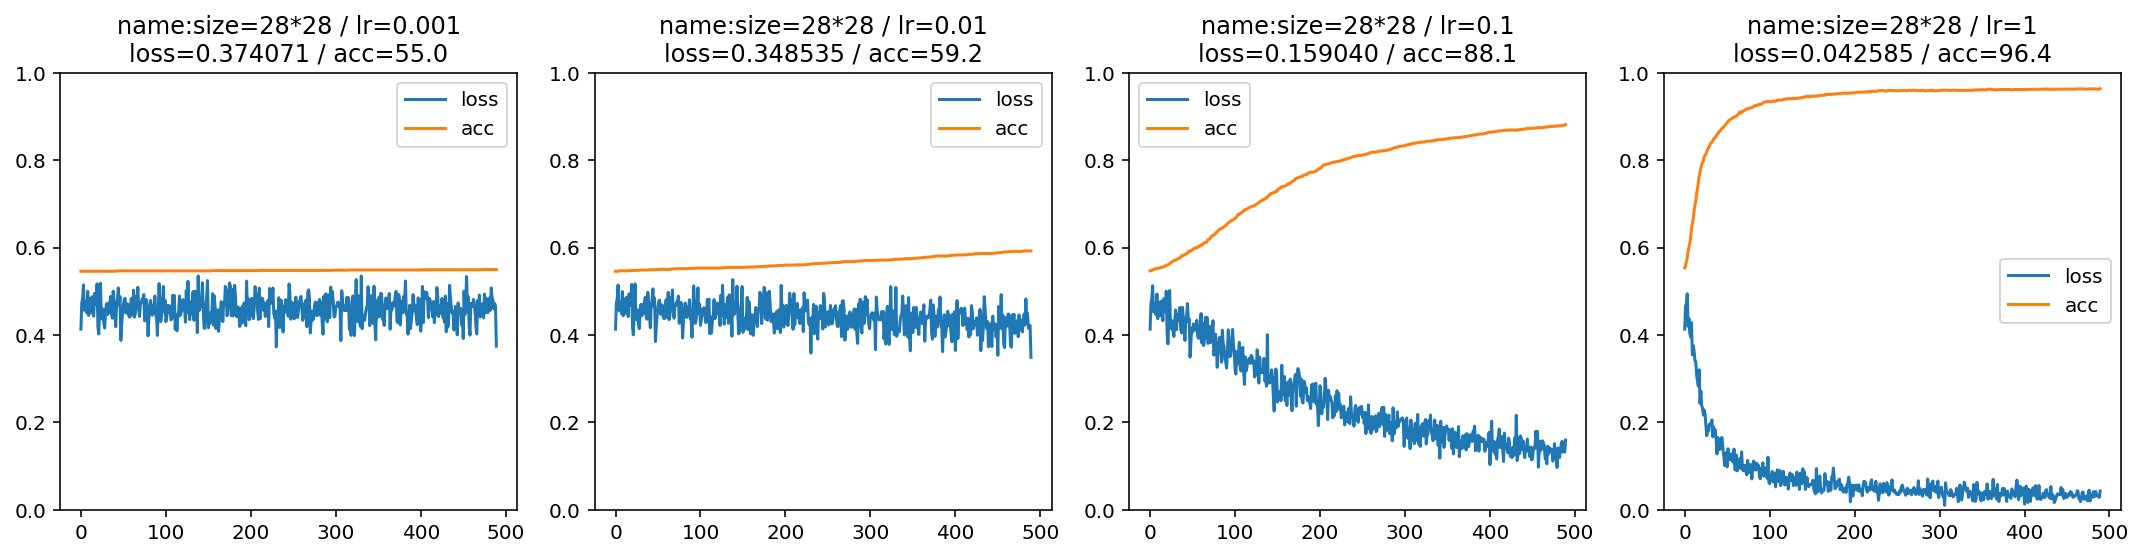

In [224]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,4))

EPOCHS=10

for ax, lr in zip(axes, (0.001, 0.01, 0.1, 1)): 
    init_random_seed()
    model = SingleLinearLayerModel(28*28, name='size=28*28')
    optimizer = ModelOptimizer(model, lr=lr)
    trainer = ModelTrainer(model, optimizer, train_x, train_y, val_x, val_y, epochs=EPOCHS)
    trainer.fit()
    trainer.plot_metrics(ax)

plt.tight_layout()

### Note:

The accuracy of 3-vs-7 using the class prototypes was 95.14, but with `lr=1` we obtain 96.4, so an improvement (yet marginal)

## Two linear layers model performance

In [231]:
class LinearLayersModel(SingleLinearLayerModel):
    def __init__(self, input_size, hidden_sizes=None, output_size=1, name=None, activation=torch.sigmoid):
        self.layers = self._get_layers(input_size, hidden_sizes, output_size)
        self.params = self._get_params(self.layers)
        self.activation = activation
        if name:
            self.name = name
        else:
            hidden_sizes = hidden_sizes if hidden_sizes else []
            self.name = '|'.join(map(str, [input_size] + list(hidden_sizes) + [output_size]))
    
    def _get_layers(self, input_size, hidden_sizes=None, output_size=1):
        sizes = [input_size]
        if hidden_sizes:
            sizes += hidden_sizes
        sizes += [output_size]
        
        layers = [
            (in_size, out_size) 
            for in_size, out_size in zip(sizes, sizes[1:])
        ]
        return layers
            
    def _get_params(self, layers):
        return [
            linear_layer(in_size, out_size) 
            for in_size, out_size in layers
        ]
    
    def predict(self, x):
        for idx, (w,b) in enumerate(self.params, start=1):
            x = x@w + b
            if idx < len(self.layers):
                x = torch.max(x, torch.zeros_like(x))
        return self.activation(x)

100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


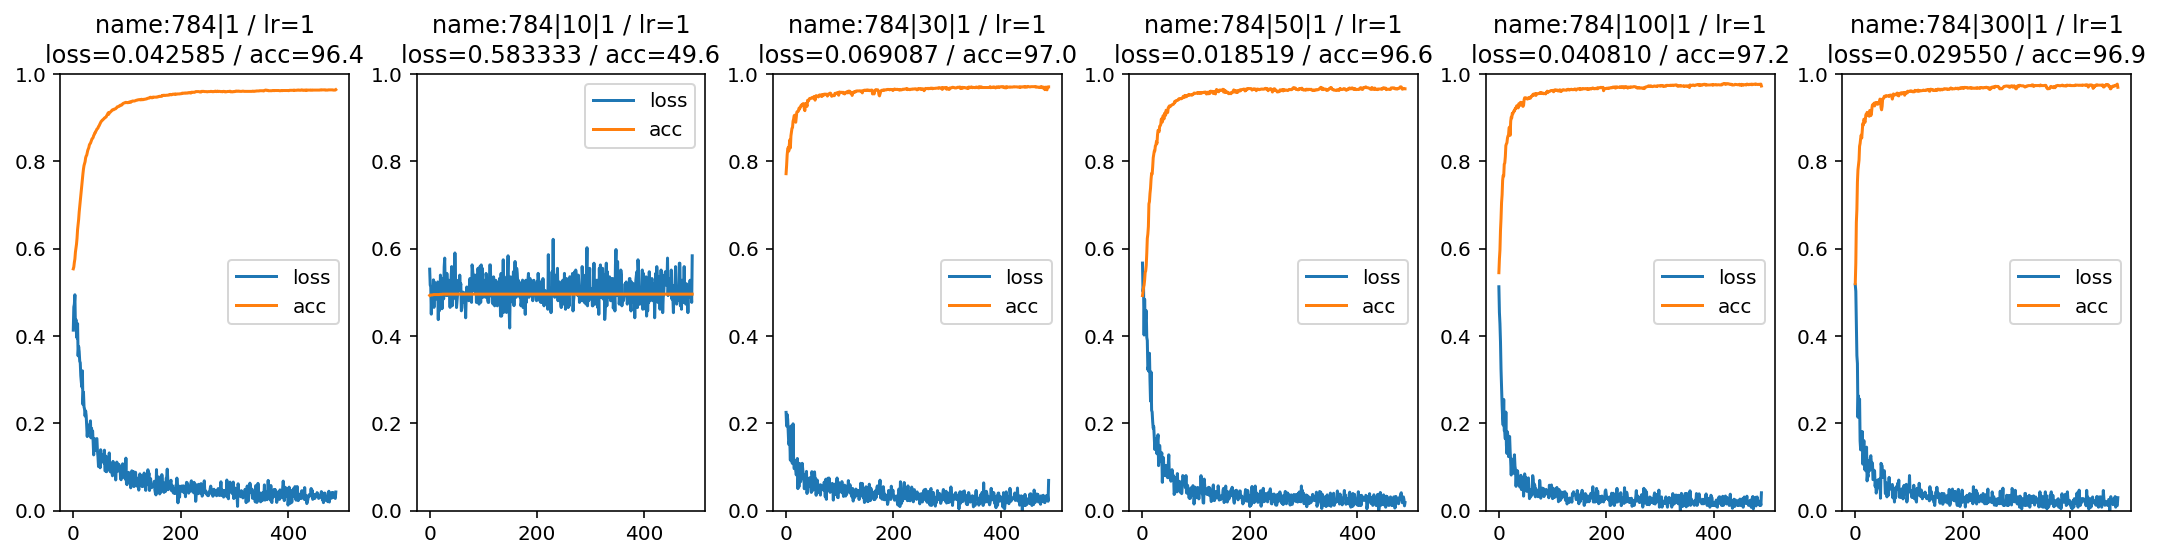

In [232]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,4))

for ax, hidden_sizes in zip(axes, (None, [10], [30], [50], [100], [300])):
    init_random_seed()
    model = LinearLayersModel(28*28, hidden_sizes, 1)
    optimizer = ModelOptimizer(model, lr=1)
    trainer = ModelTrainer(model, optimizer, train_x, train_y, val_x, val_y, epochs=10)
    trainer.fit()
    trainer.plot_metrics(ax)

plt.tight_layout()

## Three linear layers model performance

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


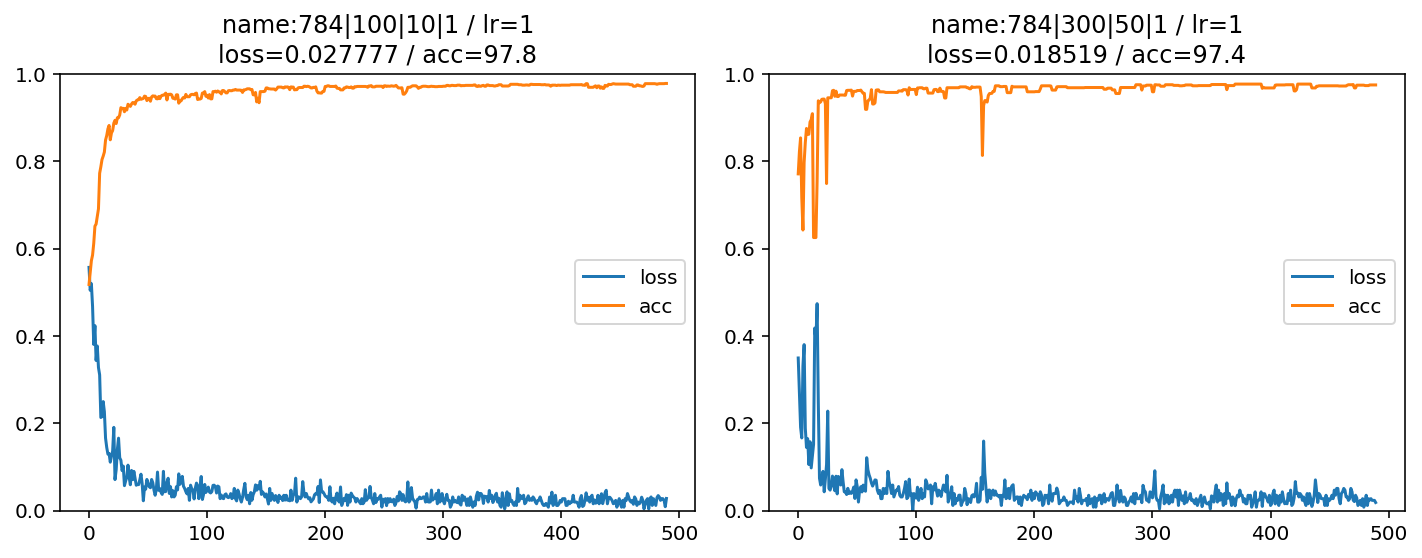

In [228]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

HIDDEN_SIZES = ((100, 10), (300, 50))
LR = 1
EPOCHS = 10

for ax, hidden_sizes in zip(axes, HIDDEN_SIZES):
    init_random_seed()
    model = LinearLayersModel(28*28, hidden_sizes, output_size=1)
    optimizer = ModelOptimizer(model, lr=LR)
    trainer = ModelTrainer(model, optimizer, train_x, train_y, val_x, val_y, epochs=EPOCHS)
    trainer.fit()
    trainer.plot_metrics(ax)
plt.tight_layout()

### Note:

Summary of performance so far of predicting 3-vs-7:
- class prototypes: 95.14% accuracy
- single layer 28*28: 96.4% accuracy
- 2 layers: best is 28*28/100/1 at 97.2% accuracy
- 3 layers: best is 28*28/100/10/1 at 97.8% accuracy

### Multi class MNIST

In [299]:
class MulticlassLinearLayersModel(LinearLayersModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def loss(self, y_pred, y_true):
        y_proba = y_pred / y_pred.sum(dim=1).view(-1, 1)
        y_proba = 1 - y_proba.gather(1, y_true.long())
        return y_proba.mean()

    def accuracy(self, y_pred, y_true):
        y_proba = y_pred / y_pred.sum(dim=1).view(-1, 1)
        _, labels = y_proba.max(dim=1)
        return (labels == y_true.squeeze()).sum().item()

100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


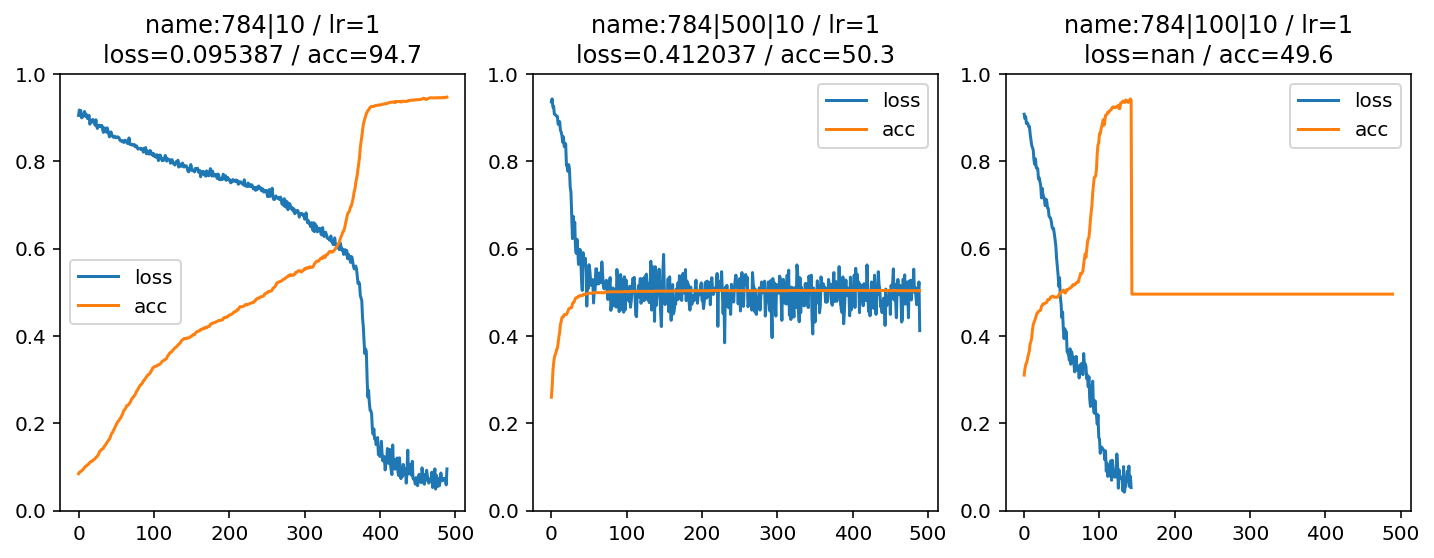

In [310]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

HIDDEN_SIZES = [
    None,  # no hidden layer
    [500], # single hidden
    [100], 
]
EPOCHS=10
LR=1

for ax, hidden_sizes in zip(axes, HIDDEN_SIZES):
    init_random_seed()
    model = MulticlassLinearLayersModel(
        input_size=28*28,
        hidden_sizes=hidden_sizes,
        output_size=10,
        name=None,
    )
    optimizer = ModelOptimizer(model, lr=LR)
    trainer = ModelTrainer(model, optimizer, train_x, train_y, val_x, val_y, epochs=EPOCHS)    
    trainer.fit()
    trainer.plot_metrics(ax)
    
plt.tight_layout()

### Note

Interestingly, using more than 1 layer generates weird behaviors (either something wrong with the code, too little data, or I'm missing some theory concepts)
Let's put a pin on this and circle back on it after going through more chapters

Anyway, using a single layer significantly outperform the 10-classes model based on class prototypes:
- class prototypes: 82.3% accuracy
- single layer: 94.7% accuracy